In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid , save_image

# Path initialization
sys.path.insert(0, "../vae_architectures")
from VAE import VAE1
from CondVAE import CondVAE

from dataset import (ATTR_TO_IX_DICT, ATTR_IX_TO_KEEP, IX_TO_ATTR_DICT, N_ATTRS, 
                     FaceData_with_Attributes, tensor_to_attributes)

%matplotlib inline

In [2]:
def show(file_name, name, img, dpi=300, fontsize=10):
    npimg = img.numpy().transpose(1, 2, 0) 
    plt.figure(dpi=dpi)
    plt.title(file_name, fontsize=fontsize)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(npimg)
    plt.savefig(name)
    plt.show()

### Conditional VAE

In [3]:
! ls ../train_vae/weights/CondVAE_Liza_24_10_2019_02_04/

details.txt
df_logs.csv
imgs
weight.epoch_2_itr_94_loss_val_0.42698121628233493.pth
weight.epoch_3_itr_94_loss_val_0.27323706766576256.pth
weight.epoch_4_itr_94_loss_val_0.22396213555608996.pth
weight.epoch_5_itr_94_loss_val_0.20166106362834232.pth
weight.epoch_6_itr_94_loss_val_0.18917736439531996.pth
weight.epoch_7_itr_94_loss_val_0.1812070325756346.pth


In [4]:
model = CondVAE(hid_dim=128, KOF=32, p=0.04, N_ATTRS=N_ATTRS)
model.load_state_dict(torch.load("../train_vae/weights/CondVAE_Liza_24_10_2019_02_04/weight.epoch_3_itr_94_loss_val_0.27323706766576256.pth"))
model = model.cuda()
model.eval()

CondVAE(
  (VAE): VAE1(
    (encoder): Sequential(
      (block01): Conv_block(
        (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block02): Conv_block(
        (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block03): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04)
        (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block04): C

In [5]:
df_attr = pd.read_csv("../data/dataframes/df_attr.csv")

img_names = {"train": df_attr.img_name.values[:55000], "val": df_attr.img_name.values[55000:]}
datasets = {phase: FaceData_with_Attributes(img_names[phase]) 
                for phase in ["train", "val"]}

dataloaders = {phase: DataLoader(datasets[phase], batch_size=128, shuffle=True, num_workers=2) 
               for phase in ["train", "val"]}

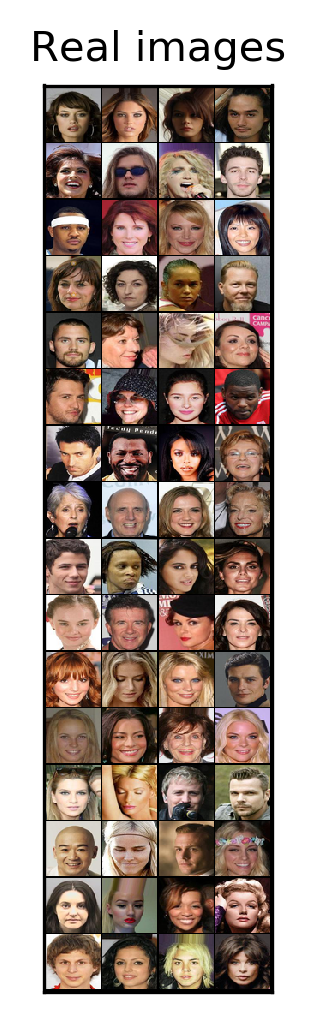

In [48]:
data, attr = next(iter(dataloaders["train"]))

show("Real images", 'ds', make_grid((data[:64]).cpu(), 4))

In [28]:
def generate_images_with_attrs(model, with_attr_list=[], no_attr_list=[], N=64, device=torch.device("cpu")):
    recon_images = []
    
    for i in range(N):
        attrs = torch.zeros(40)

        inds = np.arange(40)
        np.random.shuffle(inds)
        attrs[list(inds)[:10]] = 1
        
        for attr_name in with_attr_list:
            ind = ATTR_TO_IX_DICT[attr_name]
            attrs[ind] = 1
            
        for attr_name in no_attr_list:
            ind = ATTR_TO_IX_DICT[attr_name]
            attrs[ind] = 0

        attrs = attrs[ATTR_IX_TO_KEEP].cuda()

        recon_image, recon_attrs, mu, logvar = model(attrs=attrs[None], device=device)
        recon_image = torch.sigmoid(recon_image)
        recon_images.append(recon_image[0])
    
    recon_images = torch.stack(recon_images, dim=0)
    recon_images = recon_images.detach()
    return recon_images

#### Results

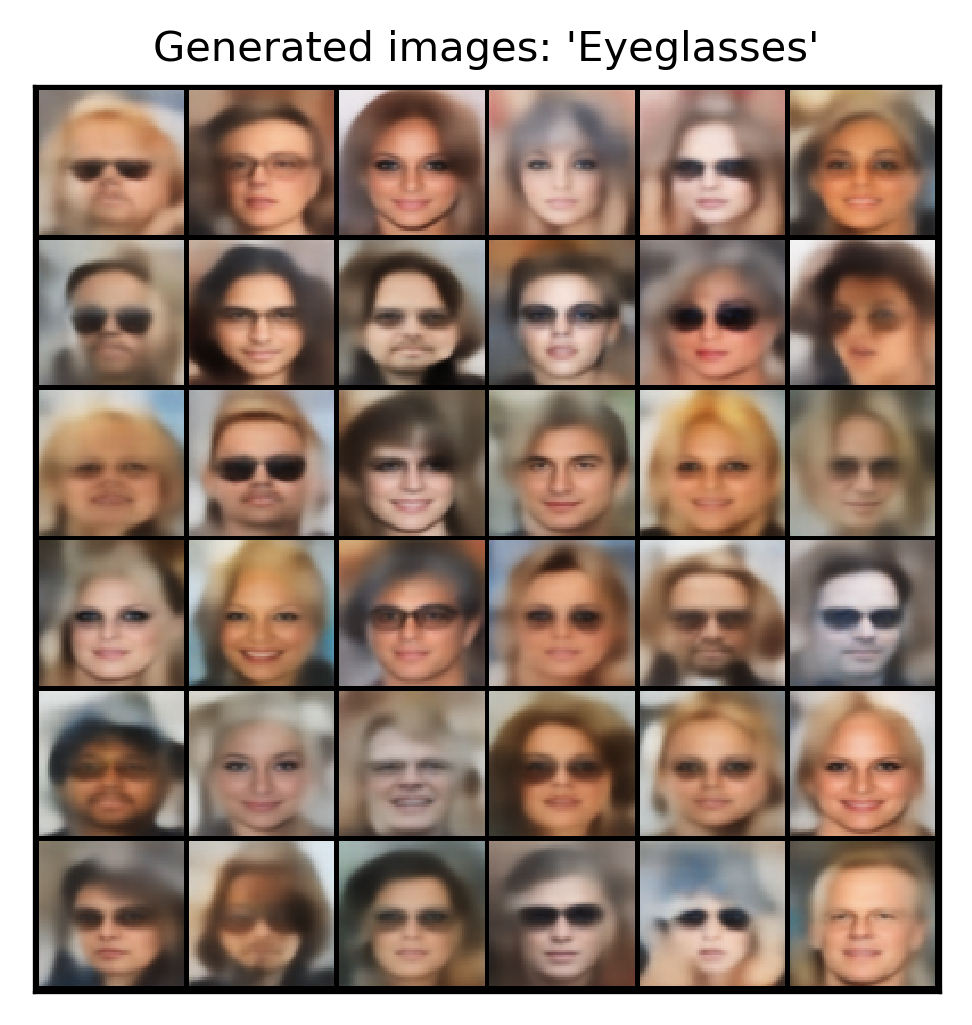

In [45]:
recon_images = generate_images_with_attrs(model, ["Eyeglasses"], N=36, device=torch.device("cuda:0"))
show("Generated images: 'Eyeglasses'", "model_good_Eyeglasses.png", make_grid((recon_images).cpu(), 6))

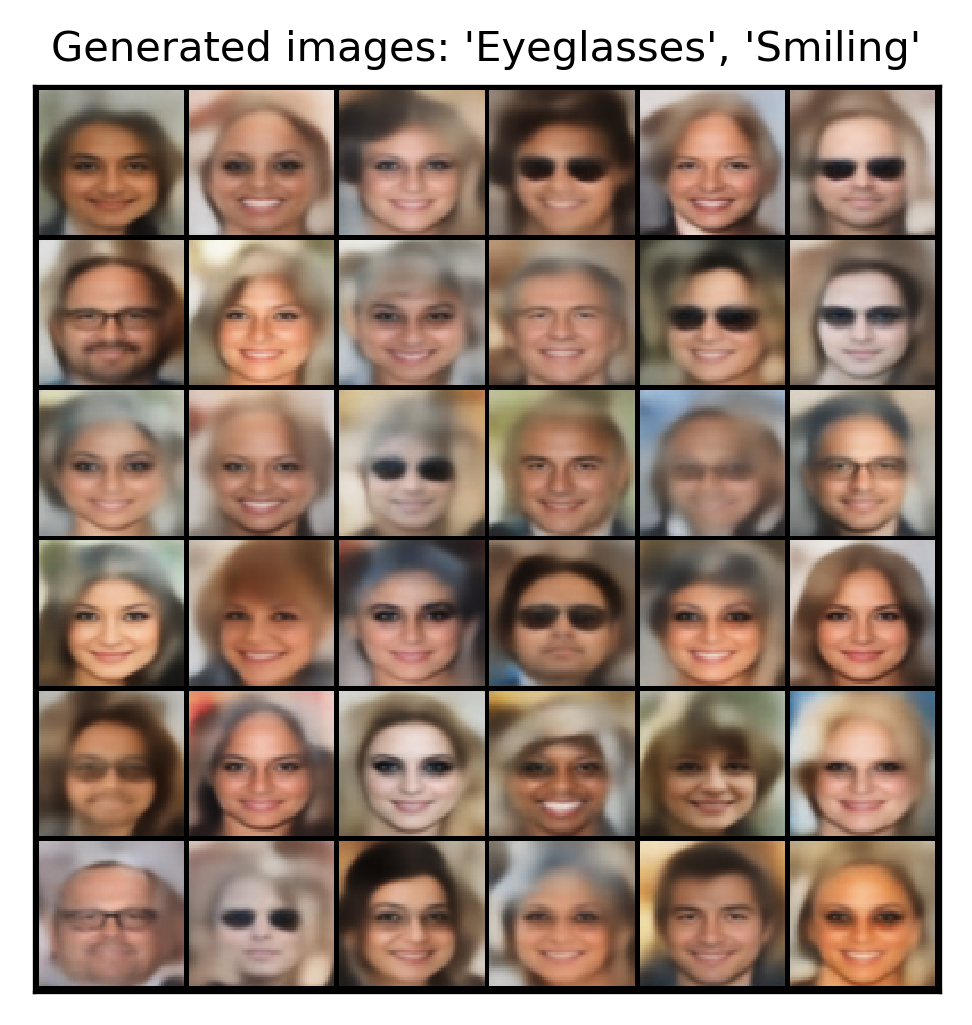

In [46]:
recon_images = generate_images_with_attrs(model, ['Eyeglasses', 'Smiling'], N=36, device=torch.device("cuda:0"))
show("Generated images: 'Eyeglasses', 'Smiling'", "model_good_Eyeglasses_Smile.png", make_grid((recon_images).cpu(), 6))

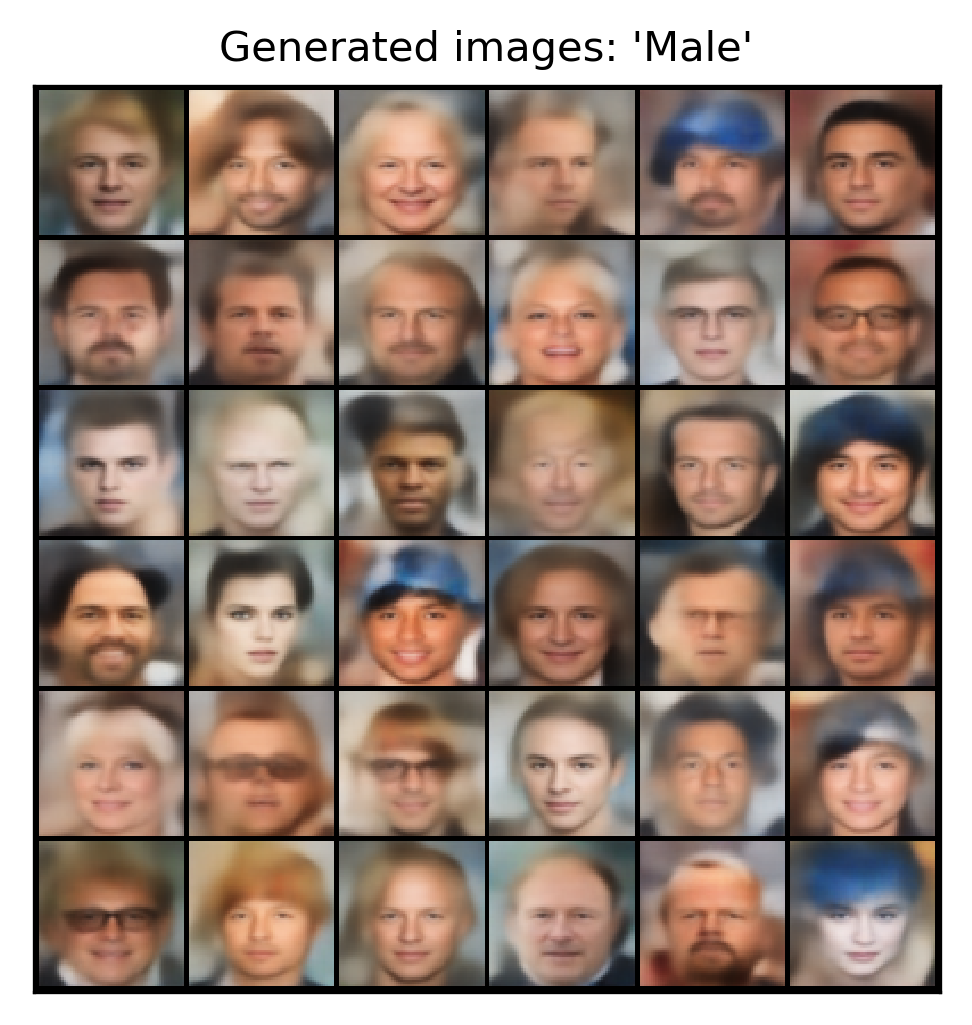

In [47]:
recon_images = generate_images_with_attrs(model, ['Male'],
                                          no_attr_list=['Heavy_Makeup', "Wearing_Lipstick"],
                                          N=36, device=torch.device("cuda:0"))
show("Generated images: 'Male'", "model_good_Male.png", make_grid((recon_images).cpu(), 6))

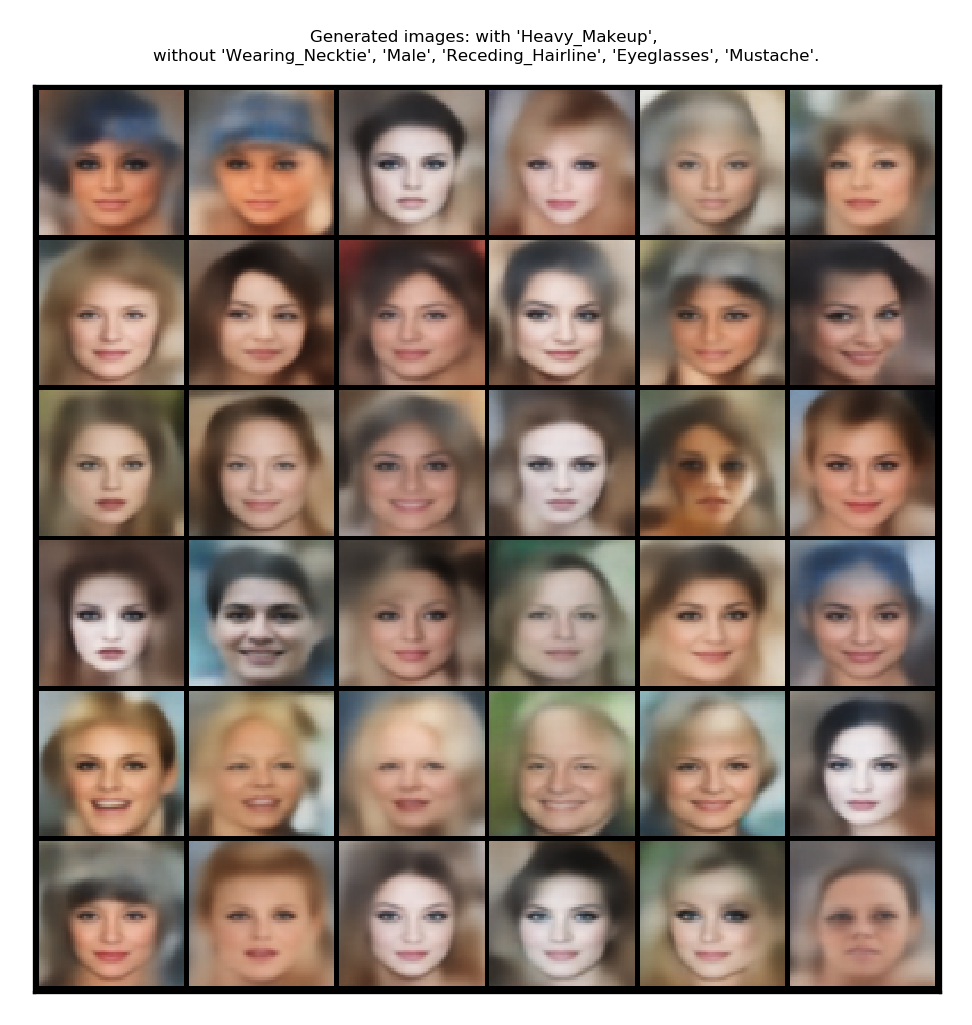

In [48]:
recon_images = generate_images_with_attrs(model, with_attr_list=['Heavy_Makeup'], 
                                          no_attr_list=["Wearing_Necktie", "Male", "Receding_Hairline",
                                                        "Mustache", "Eyeglasses"], 
                                          N=36, device=torch.device("cuda:0"))
show("Generated images: with 'Heavy_Makeup', " + 
     "\nwithout 'Wearing_Necktie', 'Male', 'Receding_Hairline', 'Eyeglasses', 'Mustache'.", 
      "model_good_Makeup.png",
     make_grid((recon_images).cpu(), 6), fontsize=4)

In [6]:
device = torch.device("cuda:0")

In [45]:
attr_name = "Eyeglasses"
Z_Mustache = []
Z_noMustache = []

In [8]:

for i, (image, attrs) in enumerate(dataloaders["train"]):
    image = image.float().to(device)
    attrs = attrs.float().to(device)
    recon_image_1, recon_attrs_1, mu_1, logvar_1 = model(image, attrs, device=device)
    
    z_hat = model.reparameterize(mu_1, logvar_1)
    
    for j in range(z_hat.shape[0]):
        print(i, j)
        
        ind = 6
        if attrs[j, ind] == 1:
            Z_Mustache.append(z_hat[j])
            
        if attrs[j, ind] == 0:
            Z_noMustache.append(z_hat[j])
            
    if i == 80:
        break


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 

13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
13 14
13 15
13 16
13 17
13 18
13 19
13 20
13 21
13 22
13 23
13 24
13 25
13 26
13 27
13 28
13 29
13 30
13 31
13 32
13 33
13 34
13 35
13 36
13 37
13 38
13 39
13 40
13 41
13 42
13 43
13 44
13 45
13 46
13 47
13 48
13 49
13 50
13 51
13 52
13 53
13 54
13 55
13 56
13 57
13 58
13 59
13 60
13 61
13 62
13 63
13 64
13 65
13 66
13 67
13 68
13 69
13 70
13 71
13 72
13 73
13 74
13 75
13 76
13 77
13 78
13 79
13 80
13 81
13 82
13 83
13 84
13 85
13 86
13 87
13 88
13 89
13 90
13 91
13 92
13 93
13 94
13 95
13 96
13 97
13 98
13 99
13 100
13 101
13 102
13 103
13 104
13 105
13 106
13 107
13 108
13 109
13 110
13 111
13 112
13 113
13 114
13 115
13 116
13 117
13 118
13 119
13 120
13 121
13 122
13 123
13 124
13 125
13 126
13 127
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
14 15
14 16
14 17
14 18
14 19
14 20
14 21
14 22
14 23
14 24
14 25
14 26
14 27
14 28
14 29
14 30
14 31
14 32
14 33
14 34
14 35
14 36
14

24 0
24 1
24 2
24 3
24 4
24 5
24 6
24 7
24 8
24 9
24 10
24 11
24 12
24 13
24 14
24 15
24 16
24 17
24 18
24 19
24 20
24 21
24 22
24 23
24 24
24 25
24 26
24 27
24 28
24 29
24 30
24 31
24 32
24 33
24 34
24 35
24 36
24 37
24 38
24 39
24 40
24 41
24 42
24 43
24 44
24 45
24 46
24 47
24 48
24 49
24 50
24 51
24 52
24 53
24 54
24 55
24 56
24 57
24 58
24 59
24 60
24 61
24 62
24 63
24 64
24 65
24 66
24 67
24 68
24 69
24 70
24 71
24 72
24 73
24 74
24 75
24 76
24 77
24 78
24 79
24 80
24 81
24 82
24 83
24 84
24 85
24 86
24 87
24 88
24 89
24 90
24 91
24 92
24 93
24 94
24 95
24 96
24 97
24 98
24 99
24 100
24 101
24 102
24 103
24 104
24 105
24 106
24 107
24 108
24 109
24 110
24 111
24 112
24 113
24 114
24 115
24 116
24 117
24 118
24 119
24 120
24 121
24 122
24 123
24 124
24 125
24 126
24 127
25 0
25 1
25 2
25 3
25 4
25 5
25 6
25 7
25 8
25 9
25 10
25 11
25 12
25 13
25 14
25 15
25 16
25 17
25 18
25 19
25 20
25 21
25 22
25 23
25 24
25 25
25 26
25 27
25 28
25 29
25 30
25 31
25 32
25 33
25 34
25 35
25 36
25

35 0
35 1
35 2
35 3
35 4
35 5
35 6
35 7
35 8
35 9
35 10
35 11
35 12
35 13
35 14
35 15
35 16
35 17
35 18
35 19
35 20
35 21
35 22
35 23
35 24
35 25
35 26
35 27
35 28
35 29
35 30
35 31
35 32
35 33
35 34
35 35
35 36
35 37
35 38
35 39
35 40
35 41
35 42
35 43
35 44
35 45
35 46
35 47
35 48
35 49
35 50
35 51
35 52
35 53
35 54
35 55
35 56
35 57
35 58
35 59
35 60
35 61
35 62
35 63
35 64
35 65
35 66
35 67
35 68
35 69
35 70
35 71
35 72
35 73
35 74
35 75
35 76
35 77
35 78
35 79
35 80
35 81
35 82
35 83
35 84
35 85
35 86
35 87
35 88
35 89
35 90
35 91
35 92
35 93
35 94
35 95
35 96
35 97
35 98
35 99
35 100
35 101
35 102
35 103
35 104
35 105
35 106
35 107
35 108
35 109
35 110
35 111
35 112
35 113
35 114
35 115
35 116
35 117
35 118
35 119
35 120
35 121
35 122
35 123
35 124
35 125
35 126
35 127
36 0
36 1
36 2
36 3
36 4
36 5
36 6
36 7
36 8
36 9
36 10
36 11
36 12
36 13
36 14
36 15
36 16
36 17
36 18
36 19
36 20
36 21
36 22
36 23
36 24
36 25
36 26
36 27
36 28
36 29
36 30
36 31
36 32
36 33
36 34
36 35
36 36
36

46 0
46 1
46 2
46 3
46 4
46 5
46 6
46 7
46 8
46 9
46 10
46 11
46 12
46 13
46 14
46 15
46 16
46 17
46 18
46 19
46 20
46 21
46 22
46 23
46 24
46 25
46 26
46 27
46 28
46 29
46 30
46 31
46 32
46 33
46 34
46 35
46 36
46 37
46 38
46 39
46 40
46 41
46 42
46 43
46 44
46 45
46 46
46 47
46 48
46 49
46 50
46 51
46 52
46 53
46 54
46 55
46 56
46 57
46 58
46 59
46 60
46 61
46 62
46 63
46 64
46 65
46 66
46 67
46 68
46 69
46 70
46 71
46 72
46 73
46 74
46 75
46 76
46 77
46 78
46 79
46 80
46 81
46 82
46 83
46 84
46 85
46 86
46 87
46 88
46 89
46 90
46 91
46 92
46 93
46 94
46 95
46 96
46 97
46 98
46 99
46 100
46 101
46 102
46 103
46 104
46 105
46 106
46 107
46 108
46 109
46 110
46 111
46 112
46 113
46 114
46 115
46 116
46 117
46 118
46 119
46 120
46 121
46 122
46 123
46 124
46 125
46 126
46 127
47 0
47 1
47 2
47 3
47 4
47 5
47 6
47 7
47 8
47 9
47 10
47 11
47 12
47 13
47 14
47 15
47 16
47 17
47 18
47 19
47 20
47 21
47 22
47 23
47 24
47 25
47 26
47 27
47 28
47 29
47 30
47 31
47 32
47 33
47 34
47 35
47 36
47

57 0
57 1
57 2
57 3
57 4
57 5
57 6
57 7
57 8
57 9
57 10
57 11
57 12
57 13
57 14
57 15
57 16
57 17
57 18
57 19
57 20
57 21
57 22
57 23
57 24
57 25
57 26
57 27
57 28
57 29
57 30
57 31
57 32
57 33
57 34
57 35
57 36
57 37
57 38
57 39
57 40
57 41
57 42
57 43
57 44
57 45
57 46
57 47
57 48
57 49
57 50
57 51
57 52
57 53
57 54
57 55
57 56
57 57
57 58
57 59
57 60
57 61
57 62
57 63
57 64
57 65
57 66
57 67
57 68
57 69
57 70
57 71
57 72
57 73
57 74
57 75
57 76
57 77
57 78
57 79
57 80
57 81
57 82
57 83
57 84
57 85
57 86
57 87
57 88
57 89
57 90
57 91
57 92
57 93
57 94
57 95
57 96
57 97
57 98
57 99
57 100
57 101
57 102
57 103
57 104
57 105
57 106
57 107
57 108
57 109
57 110
57 111
57 112
57 113
57 114
57 115
57 116
57 117
57 118
57 119
57 120
57 121
57 122
57 123
57 124
57 125
57 126
57 127
58 0
58 1
58 2
58 3
58 4
58 5
58 6
58 7
58 8
58 9
58 10
58 11
58 12
58 13
58 14
58 15
58 16
58 17
58 18
58 19
58 20
58 21
58 22
58 23
58 24
58 25
58 26
58 27
58 28
58 29
58 30
58 31
58 32
58 33
58 34
58 35
58 36
58

68 0
68 1
68 2
68 3
68 4
68 5
68 6
68 7
68 8
68 9
68 10
68 11
68 12
68 13
68 14
68 15
68 16
68 17
68 18
68 19
68 20
68 21
68 22
68 23
68 24
68 25
68 26
68 27
68 28
68 29
68 30
68 31
68 32
68 33
68 34
68 35
68 36
68 37
68 38
68 39
68 40
68 41
68 42
68 43
68 44
68 45
68 46
68 47
68 48
68 49
68 50
68 51
68 52
68 53
68 54
68 55
68 56
68 57
68 58
68 59
68 60
68 61
68 62
68 63
68 64
68 65
68 66
68 67
68 68
68 69
68 70
68 71
68 72
68 73
68 74
68 75
68 76
68 77
68 78
68 79
68 80
68 81
68 82
68 83
68 84
68 85
68 86
68 87
68 88
68 89
68 90
68 91
68 92
68 93
68 94
68 95
68 96
68 97
68 98
68 99
68 100
68 101
68 102
68 103
68 104
68 105
68 106
68 107
68 108
68 109
68 110
68 111
68 112
68 113
68 114
68 115
68 116
68 117
68 118
68 119
68 120
68 121
68 122
68 123
68 124
68 125
68 126
68 127
69 0
69 1
69 2
69 3
69 4
69 5
69 6
69 7
69 8
69 9
69 10
69 11
69 12
69 13
69 14
69 15
69 16
69 17
69 18
69 19
69 20
69 21
69 22
69 23
69 24
69 25
69 26
69 27
69 28
69 29
69 30
69 31
69 32
69 33
69 34
69 35
69 36
69

79 25
79 26
79 27
79 28
79 29
79 30
79 31
79 32
79 33
79 34
79 35
79 36
79 37
79 38
79 39
79 40
79 41
79 42
79 43
79 44
79 45
79 46
79 47
79 48
79 49
79 50
79 51
79 52
79 53
79 54
79 55
79 56
79 57
79 58
79 59
79 60
79 61
79 62
79 63
79 64
79 65
79 66
79 67
79 68
79 69
79 70
79 71
79 72
79 73
79 74
79 75
79 76
79 77
79 78
79 79
79 80
79 81
79 82
79 83
79 84
79 85
79 86
79 87
79 88
79 89
79 90
79 91
79 92
79 93
79 94
79 95
79 96
79 97
79 98
79 99
79 100
79 101
79 102
79 103
79 104
79 105
79 106
79 107
79 108
79 109
79 110
79 111
79 112
79 113
79 114
79 115
79 116
79 117
79 118
79 119
79 120
79 121
79 122
79 123
79 124
79 125
79 126
79 127
80 0
80 1
80 2
80 3
80 4
80 5
80 6
80 7
80 8
80 9
80 10
80 11
80 12
80 13
80 14
80 15
80 16
80 17
80 18
80 19
80 20
80 21
80 22
80 23
80 24
80 25
80 26
80 27
80 28
80 29
80 30
80 31
80 32
80 33
80 34
80 35
80 36
80 37
80 38
80 39
80 40
80 41
80 42
80 43
80 44
80 45
80 46
80 47
80 48
80 49
80 50
80 51
80 52
80 53
80 54
80 55
80 56
80 57
80 58
80 59
80 6

In [9]:
torch.stack(Z_Mustache).shape

torch.Size([673, 128])

In [10]:
Z_Mustache_mean = torch.mean(torch.stack(Z_Mustache), dim=0)
Z_noMustache_mean = torch.mean(torch.stack(Z_noMustache), dim=0)

Z_Mustache_move = Z_Mustache_mean - Z_noMustache_mean

In [11]:
z_hat.shape

torch.Size([128, 128])

In [12]:
attrs.shape

torch.Size([128, 18])

In [77]:
# Attr
recon_image, recon_attrs, mu, logvar = model(attrs=attrs[None], device=device)
z_hat = model.reparameterize(mu, logvar)

attrs_recons = []
for alpha in [0., 0.55, 1., 1.2, 1.5, 2.]:
    attrs = torch.zeros(40)
    inds = np.arange(40)
    np.random.shuffle(inds)
    attrs[list(inds)[:5]] = 1

    for attr_name in []:
        ind = ATTR_TO_IX_DICT[attr_name]
        attrs[ind] = 1

    for attr_name in ['Mustache']:
        ind = ATTR_TO_IX_DICT[attr_name]
        attrs[ind] = 0

    attrs = attrs[ATTR_IX_TO_KEEP].cuda()

    # 
    
    z_hat_i = z_hat + alpha * Z_Mustache_move

    mu_x, logvar_x = model.VAE.p_x(z_hat_i)

    attrs_recons.append(torch.sigmoid(mu_x))
    
#     plt.imshow(torch.sigmoid(mu_x[0]).detach().cpu().numpy().transpose(1, 2, 0))

In [ ]:
torch.stack(attrs_recons, dim=1)[0].shape
Z = torch.stack(attrs_recons, dim=1)[0]
Z = Z.detach()

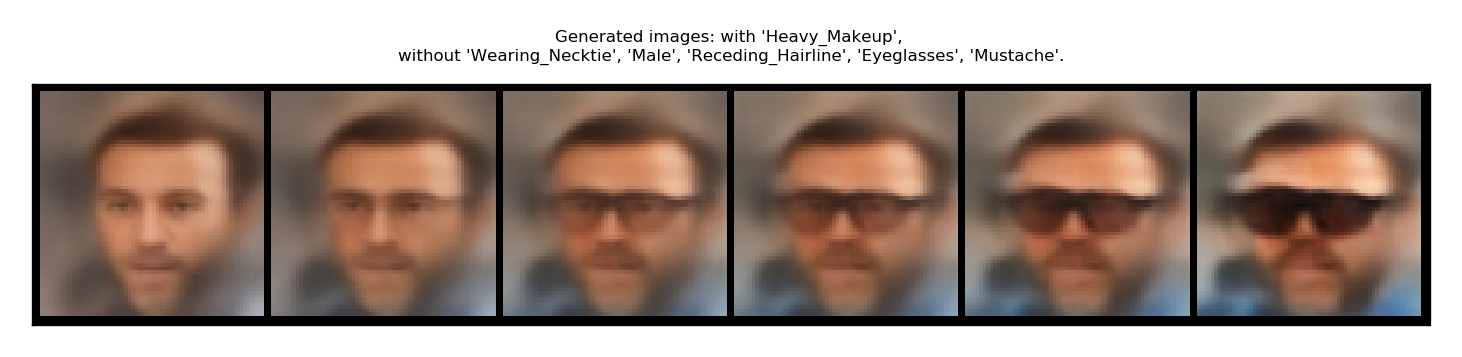

In [76]:
show("Generated images: with 'Heavy_Makeup', " + 
     "\nwithout 'Wearing_Necktie', 'Male', 'Receding_Hairline', 'Eyeglasses', 'Mustache'.", 
      "model_good_Makeup.png",
     make_grid(Z.cpu(), 6), fontsize=4)

In [93]:
mu_x[0].shape

torch.Size([3, 64, 64])

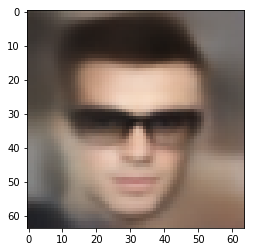

In [132]:
device = torch.device("cuda:0")

attrs = torch.zeros(40)

ind = np.arange(40)
np.random.shuffle(ind)
attrs[list(ind)[:10]] = 1
attrs[15] = 1

attrs = attrs[ATTR_IX_TO_KEEP].cuda()
attrs

recon_image_3, recon_attrs_3, mu_3, logvar_3 = model(attrs=attrs[None], device=device)
recon_image_3 = torch.sigmoid(recon_image_3)

plt.imshow(recon_image_3[0].detach().cpu().numpy().transpose(1, 2, 0))